In [80]:
import os
import time
import numpy as np
import torch
from matplotlib import pyplot as plt, gridspec
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm, trange
from pyDOE import lhs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)
adam_lr, LBFGS_lr = 0.001, 0.5
adam_iter, LBFGS_iter = 50000, 500000
AM_count = 20
AM_type = 1
AM_K = 1
M = 1000
N = 3000
AW_lr = 0.001
model_type = 0
lb = np.array([0, 0, 0])
ub = np.array([2*np.pi, 2*np.pi, 1])

GPU: False


In [81]:
def random_fun(lb, ub, num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(3, num)).float()
    if use_gpu:
        temp = temp.cuda()
    return temp

In [82]:
def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

In [83]:
class Net1(nn.Module):
    def __init__(self, layers):
        super(Net1, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [84]:
class Net2(nn.Module):
    def __init__(self, layers):
        super(Net2, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [113]:
class Model:
    def __init__(self, net1,net2,x_bc,u_bc,v_bc,x_ic,u_ic,v_ic,
                 x_f_loss_fun,x_test,x_test_exact_u,x_test_exact_v):
        self.net1 = net1
        self.net2 = net2
        self.x_ic_s = None
        self.x_bc_s = None
        self.x_f_s = None
        self.x_f_N = None
        self.x_f_M = None
        self.x_f_loss_fun = x_f_loss_fun
        self.x_ic = x_ic
        self.u_ic = u_ic
        self.v_ic = v_ic
        self.x_bc = x_bc
        self.u_bc = u_bc
        self.v_bc = v_bc
        self.optimizer_LBFGS_u = None
        self.optimizer_LBFGS_v = None
        self.x_test = x_test
        self.x_test_exact_u = x_test_exact_u
        self.x_test_exact_v = x_test_exact_v
        self.x_f_N = None
        self.x_f_M = None
        self.start_loss_collect = False
        self.x_label_loss_collect = []
        self.x_f_loss_collect = []
        self.x_test_estimate_collect = []
        self.s_collect = []
             
    def train_U(self,x):
        return self.net1(x)
    
    def train_V(self,x):
        return self.net2(x)
    
    def predict_U(self, x):
        return self.train_U(x)
    
    def predict_V(self, x):
        return self.train_V(x)
    
    def likelihood_loss(self, loss_e, loss_ic, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
               + torch.exp(-self.x_ic_s) * loss_ic.detach() + self.x_ic_s \
               + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss
    
    def true_loss(self, loss_e, loss_ic, loss_bc):
        return torch.exp(-self.x_f_s.detach()) * loss_e + torch.exp(-self.x_ic_s.detach()) * loss_ic + torch.exp(
            -self.x_bc_s.detach()) * loss_bc
    
    # 计算迭代损失
    def epoch_loss(self):
        x_f = torch.cat((self.x_f_N,self.x_f_M), dim=0)
        f1, f2 = self.x_f_loss_fun(x_f,self.train_U,self.train_V)
        loss_equation = torch.mean(f1 ** 2 + f2 ** 2)
        
        loss_ic = torch.mean((self.train_U(self.x_ic) - self.u_ic) ** 2 + (self.train_V(self.x_ic) - self.v_ic) ** 2)
        
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2 + (self.train_V(self.x_bc) - self.v_bc) ** 2)
        # 控制方程损失，初始条件损失以及边界条件损失
        return loss_equation, loss_ic, loss_bc
    
    # LBFGS迭代损失函数
    def LBFGS_epoch_loss(self):
        self.optimizer_LBFGS_u.zero_grad()
        self.optimizer_LBFGS_v.zero_grad()
        x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        f1, f2 = self.x_f_loss_fun(x_f,self.train_U,self.train_V)
        loss_equation = torch.mean(f1 ** 2 + f2 ** 2)
        loss_ic = torch.mean((self.train_U(self.x_ic) - self.u_ic) ** 2 + (self.train_V(self.x_ic) - self.v_ic) ** 2)
        
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2 + (self.train_V(self.x_bc) - self.v_bc) ** 2)
        loss = self.true_loss(loss_equation, loss_ic, loss_bc)
        loss.backward()
        self.net1.iter += 1
        self.net2.iter += 1
        # print('Iter:', self.net1.iter, 'Loss:', loss.item())
        return loss
    
    def evaluate(self):
        pred_u = self.train_U(self.x_test).cpu().detach().numpy()
        pred_v = self.train_V(self.x_test).cpu().detach().numpy()
        exact_u = self.x_test_exact_u.cpu().detach().numpy()
        exact_v = self.x_test_exact_v.cpu().detach().numpy()
        error_u = np.sqrt(np.sum(np.square(pred_u - exact_u))) / np.sqrt(np.sum(np.square(exact_u)))
        error_v = np.sqrt(np.sum(np.square(pred_v - exact_v))) / np.sqrt(np.sum(np.square(exact_v)))
        # error_u = np.linalg.norm(pred_u - exact_u, 2) / np.linalg.norm(exact_u, 2)
        # error_v = np.linalg.norm(pred_v - exact_v, 2) / np.linalg.norm(exact_v, 2)
        return error_u,error_v
    
    def run_baseline(self):
        optimizer_adam_u = torch.optim.Adam(self.net1.parameters(), lr = adam_lr)
        optimizer_adam_v = torch.optim.Adam(self.net2.parameters(), lr = adam_lr)
        self.optimizer_LBFGS_u = torch.optim.LBFGS(self.net1.parameters(),lr = LBFGS_lr,
                                                 max_iter=LBFGS_iter)
        self.optimizer_LBFGS_v = torch.optim.LBFGS(self.net2.parameters(),lr = LBFGS_lr,
                                                 max_iter=LBFGS_iter)
        pbar = trange(adam_iter, ncols=100)
        for i in pbar:
            optimizer_adam_u.zero_grad()
            optimizer_adam_v.zero_grad()
            loss_e,loss_ic,loss_bc = self.epoch_loss()
            loss = self.true_loss(loss_e, loss_ic, loss_bc)
            loss.backward()
            optimizer_adam_u.step()
            optimizer_adam_v.step()
            self.net1.iter += 1
            self.net2.iter += 1
            pbar.set_postfix({'Iter':self.net1.iter,
                              'Loss':'{0:.2e}'.format(loss.item())
                              }) 
        print('Adam done!')
        #这一块可能有问题，到时候再看
        # pbar = trange(LBFGS_iter, ncols=100)
        # for _ in pbar:
        self.optimizer_LBFGS_u.step(self.LBFGS_epoch_loss)
        self.optimizer_LBFGS_v.step(self.LBFGS_epoch_loss)
            # pbar.set_postfix({'Iter':self.net1.iter
            #                   }) 
        print('LBFGS done!')
        
        error_u, error_v = self.evaluate()
        print('Test_L2error_u:', '{0:.2e}'.format(error_u))
        print('Test_L2error_v:', '{0:.2e}'.format(error_v))
        
    def run_AM(self):
        for move_count in range(AM_count):
            optimizer_adam_u = torch.optim.Adam(self.net1.parameters(), lr = adam_lr)
            optimizer_adam_v = torch.optim.Adam(self.net2.parameters(), lr = adam_lr)
            self.optimizer_LBFGS_u = torch.optim.LBFGS(self.net1.parameters(),lr = LBFGS_lr,
                                                    max_iter=LBFGS_iter)
            self.optimizer_LBFGS_v = torch.optim.LBFGS(self.net2.parameters(),lr = LBFGS_lr,
                                                    max_iter=LBFGS_iter)
            pbar = trange(adam_iter, ncols=100)
            for i in pbar:
                optimizer_adam_u.zero_grad()
                optimizer_adam_v.zero_grad()
                loss_e,loss_ic,loss_bc = self.epoch_loss()
                loss = self.true_loss(loss_e, loss_ic, loss_bc)
                loss.backward()
                optimizer_adam_u.step()
                optimizer_adam_v.step()
                self.net1.iter += 1
                self.net2.iter += 1
                pbar.set_postfix({'Iter':self.net1.iter,
                                'Loss':'{0:.2e}'.format(loss.item())
                                }) 
            print('Adam done!')
            #这一块可能有问题，到时候再看
            self.optimizer_LBFGS_u.step(self.LBFGS_epoch_loss)
            self.optimizer_LBFGS_v.step(self.LBFGS_epoch_loss)
            print('LBFGS done!')
            
            error_u, error_v = self.evaluate()
            print('change_counts', move_count, 'Test_L2error_u:', '{0:.2e}'.format(error_u),'Test_L2error_v:', '{0:.2e}'.format(error_v))
            self.x_test_estimate_collect.append([move_count, '{0:.2e}'.format(error_u),'{0:.2e}'.format(error_v)])

            
            if AM_type == 0: #基于残差，分配点向残差大的地方移动
                x_init = random_fun(lb,ub,100000)
                f1, f2 = self.x_f_loss_fun(x_init,self.train_U,self.train_V)
                x_init_residual = abs(f1) + abs(f2)
                x_init_residual = x_init_residual.cpu().detach().numpy()
                err_eq = np.power(x_init_residual, AM_K) / np.power(x_init_residual, AM_K).mean()
                err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=err_eq_normalized)
                self.x_f_M = x_init[X_ids]
                
            elif AM_type == 1:
                x_init = random_fun(lb,ub,100000)
                x = Variable(x_init,requires_grad=True)
                u = self.train_U(x)
                v = self.train_V(x)
                dux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                dvx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                grad_ux = dux[:[0]].squeeze()
                grad_uy = dux[:[1]].squeeze()
                grad_ut = dux[:[2]].squeeze()
                grad_vx = dvx[:[0]].squeeze()
                grad_vy = dvx[:[0]].squeeze()
                grad_vt = dvx[:[0]].squeeze()
                dx = torch.sqrt(1 + grad_ux ** 2 + grad_uy ** 2 + grad_ut ** 2
                                + grad_vx ** 2 + grad_vy ** 2 + grad_vt ** 2).cpu().detach().numpy()
                err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
                p = (err_dx / sum(err_dx))
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=p)
                self.x_f_M = x_init[X_ids]
                
    def run_AM_AW(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_ic_s = nn.Parameter(self.x_ic_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        for move_count in range(AM_count):
            optimizer_adam_u = torch.optim.Adam(self.net1.parameters(), lr = adam_lr)
            optimizer_adam_v = torch.optim.Adam(self.net2.parameters(), lr = adam_lr)
            self.optimizer_LBFGS_u = torch.optim.LBFGS(self.net1.parameters(),lr = LBFGS_lr,
                                                    max_iter=LBFGS_iter)
            self.optimizer_LBFGS_v = torch.optim.LBFGS(self.net2.parameters(),lr = LBFGS_lr,
                                                    max_iter=LBFGS_iter)
            optimizer_adam_weight = torch.optim.Adam([self.x_f_s] + [self.x_ic_s] + [self.x_bc_s],
                                                        lr=AW_lr)
            pbar = trange(adam_iter, ncols=100)
            for i in pbar:
                self.s_collect.append([self.net1.iter, self.x_f_s.item(), self.x_ic_s.item(), self.x_bc_s.item()])
                optimizer_adam_u.zero_grad()
                optimizer_adam_v.zero_grad()
                loss_e,loss_ic,loss_bc = self.epoch_loss()
                loss = self.true_loss(loss_e, loss_ic, loss_bc)
                loss.backward()
                optimizer_adam_u.step()
                optimizer_adam_v.step()
                self.net1.iter += 1
                self.net2.iter += 1
                pbar.set_postfix({'Iter':self.net1.iter,
                                'Loss':'{0:.2e}'.format(loss.item())
                                }) 
                optimizer_adam_weight.zero_grad()
                loss = self.likelihood_loss(loss_e, loss_ic, loss_bc)
                loss.backward()
                optimizer_adam_weight.step()
                
            print('Adam done!')
            #这一块可能有问题，到时候再看
            self.optimizer_LBFGS_u.step(self.LBFGS_epoch_loss)
            self.optimizer_LBFGS_v.step(self.LBFGS_epoch_loss)
            print('LBFGS done!')
            
            error_u, error_v = self.evaluate()
            print('change_counts', move_count, 'Test_L2error_u:', '{0:.2e}'.format(error_u),'Test_L2error_v:', '{0:.2e}'.format(error_v))
            self.x_test_estimate_collect.append([move_count, '{0:.2e}'.format(error_u),'{0:.2e}'.format(error_v)])
            
            if AM_type == 0: #基于残差，分配点向残差大的地方移动
                x_init = random_fun(lb,ub,100000)
                f1, f2 = self.x_f_loss_fun(x_init,self.train_U,self.train_V)
                x_init_residual = abs(f1) + abs(f2)
                x_init_residual = x_init_residual.cpu().detach().numpy()
                err_eq = np.power(x_init_residual, AM_K) / np.power(x_init_residual, AM_K).mean()
                err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=err_eq_normalized)
                self.x_f_M = x_init[X_ids]
                
            elif AM_type == 1:
                x_init = random_fun(lb,ub,100000)
                x = Variable(x_init,requires_grad=True)
                u = self.train_U(x)
                v = self.train_V(x)
                dux = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                dvx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                grad_ux = dux[:, [0]].squeeze()
                grad_uy = dux[:, [1]].squeeze()
                grad_ut = dux[:, [2]].squeeze()
                grad_vx = dvx[:, [0]].squeeze()
                grad_vy = dvx[:, [1]].squeeze()
                grad_vt = dvx[:, [2]].squeeze()
                dx = torch.sqrt(1 + grad_ux ** 2 + grad_uy ** 2 + grad_ut ** 2
                                + grad_vx ** 2 + grad_vy ** 2 + grad_vt ** 2).cpu().detach().numpy()
                err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
                p = (err_dx / sum(err_dx))
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=p)
                self.x_f_M = x_init[X_ids]
        
    def train(self):
        self.x_f_N = random_fun(lb = lb,ub = ub,num = N)
        self.x_f_M = random_fun(lb = lb,ub = ub,num = M)
        
        self.x_f_s = is_cuda(torch.tensor(0.).float())
        self.x_ic_s = is_cuda(torch.tensor(0.).float())
        self.x_bc_s = is_cuda(torch.tensor(0.).float())
        
        start_time = time.time()
        if model_type == 0:
            print("run PINN")
            self.run_baseline()
        elif model_type == 1:
            print("run AM")
            self.run_AM()
        elif model_type == 2:
            print("run AM_AW")
            self.run_AM_AW()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

        

In [88]:
def x_f_loss_fun(x, train_U, train_V):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x)
    du = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)
    u_x = du[0][:, 0].unsqueeze(-1)
    u_y = du[0][:, 1].unsqueeze(-1)
    u_t = du[0][:, 2].unsqueeze(-1)
    d_ux = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)
    u_xx = d_ux[0][:, 0].unsqueeze(-1)
    d_uy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_x), create_graph=True)
    u_yy = d_uy[0][:, 1].unsqueeze(-1)
    
    v = train_V(x)
    dv = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)
    v_x = dv[0][:, 0].unsqueeze(-1)
    v_y = dv[0][:, 1].unsqueeze(-1)
    v_t = dv[0][:, 2].unsqueeze(-1)
    d_vx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)
    v_xx = d_vx[0][:, 0].unsqueeze(-1)
    d_vy = torch.autograd.grad(v_y, x, grad_outputs=torch.ones_like(v_y), create_graph=True)
    v_yy = d_vy[0][:, 1].unsqueeze(-1)
    
    f1 = u_t - u * u * u_x - v * v * u_y
    f2 = v_t - u * u * v_x - v * v * v_y
    return f1,f2
     

In [89]:
#设置参数
layers = [3, 20, 20, 20, 20, 1]
net1 = is_cuda(Net1(layers))
net2 = is_cuda(Net2(layers))
def exact_u(x):
    return np.sin(x[:, [0]]+x[:, [1]]+x[:, [2]])
def exact_v(x):
    return np.cos(x[:, [0]]+x[:, [1]]+x[:, [2]])
lb = np.array([0, 0, 0])
ub = np.array([2*np.pi, 2*np.pi, 1])

In [90]:
#准备数据
#test data
#解析解已知的情况
P=100 #测试点个数P*P*P
x = np.expand_dims(np.linspace(0, 2*np.pi, P), axis=1)
y = np.expand_dims(np.linspace(0, 2*np.pi, P), axis=1)
t = np.expand_dims(np.linspace(0, 1, P), axis=1)
X, Y, T = np.meshgrid(x, y, t) #P*P*P网格
x_test_np = np.concatenate((np.expand_dims(X.flatten(), axis=1), np.expand_dims(Y.flatten(), axis=1),np.expand_dims(T.flatten(), axis=1)), axis=-1)#(P*P*P,3)
solution_u = exact_u(x_test_np)
solution_v = exact_v(x_test_np)
x_test = is_cuda(torch.from_numpy(x_test_np).float())
x_test_exact_u = is_cuda(torch.from_numpy(solution_u).float())
x_test_exact_v = is_cuda(torch.from_numpy(solution_v).float())

In [91]:
# 初始数据
Nic = 200 #初始数据个数
x_init = torch.full([Nic, 2], -1) + torch.rand([Nic, 2]) * 2 #-1,1之间的随机数
x_init = torch.rand([Nic, 2]) * 2 * np.pi #0,2pi之间的随机数
# x_init = torch.rand([Nic, 2]) #0,1之间的随机数
x_initial = torch.cat(( x_init, torch.zeros(Nic, 1)), dim=1)
x_initial_u = torch.sin(x_initial[:, [0]] + x_initial[:, [1]])
x_initial_v = torch.cos(x_initial[:, [0]] + x_initial[:, [1]])

In [92]:
# 边界数据    
Nbc = 200 #边界数据个数 
# # 左边界
# x1_boundary_left = torch.cat((torch.full([Nbc, 1], -1), torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.rand([Nbc, 1])), dim=1)
# # 右边界
# x1_boundary_right = torch.cat((torch.full([Nbc, 1], 1), torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.rand([Nbc, 1])), dim=1)
# # 下边界
# x2_boundary_left = torch.cat((torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.full([Nbc, 1], -1), torch.rand([Nbc, 1])), dim=1)
# # 上边界
# x2_boundary_right = torch.cat((torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.full([Nbc, 1], 1), torch.rand([Nbc, 1])), dim=1)

# 左边界
x1_boundary_left = torch.cat((torch.full([Nbc, 1], 0), torch.rand([Nic, 1]) * 2 * np.pi, torch.rand([Nbc, 1])), dim=1)
# 右边界
x1_boundary_right = torch.cat((torch.full([Nbc, 1], 2 * np.pi), torch.rand([Nic, 1]) * 2 * np.pi, torch.rand([Nbc, 1])), dim=1)
# 下边界
x2_boundary_left = torch.cat((torch.rand([Nic, 1]) * 2 * np.pi, torch.full([Nbc, 1], 0), torch.rand([Nbc, 1])), dim=1)
# 上边界
x2_boundary_right = torch.cat((torch.rand([Nic, 1]) * 2 * np.pi, torch.full([Nbc, 1], 2 * np.pi), torch.rand([Nbc, 1])), dim=1)

#真实值
x1_boundary_left_label_u = torch.from_numpy(
        exact_u(x1_boundary_left.numpy())).float()
x1_boundary_right_label_u = torch.from_numpy(
        exact_u(x1_boundary_right.numpy())).float()
x2_boundary_left_label_u = torch.from_numpy(
        exact_u(x2_boundary_left.numpy())).float()
x2_boundary_right_label_u = torch.from_numpy(
        exact_u(x2_boundary_right.numpy())).float()
x1_boundary_left_label_v = torch.from_numpy(
        exact_v(x1_boundary_left.numpy())).float()
x1_boundary_right_label_v = torch.from_numpy(
        exact_v(x1_boundary_right.numpy())).float()
x2_boundary_left_label_v = torch.from_numpy(
        exact_v(x2_boundary_left.numpy())).float()
x2_boundary_right_label_v = torch.from_numpy(
        exact_v(x2_boundary_right.numpy())).float()

# x1_boundary_left_label_u = torch.zeros([Nbc, 1])
# x1_boundary_right_label_u = torch.zeros([Nbc, 1])
# x2_boundary_left_label_u = torch.zeros([Nbc, 1])
# x2_boundary_right_label_u = torch.zeros([Nbc, 1])
# x1_boundary_left_label_v = torch.zeros([Nbc, 1])
# x1_boundary_right_label_v = torch.zeros([Nbc, 1])
# x2_boundary_left_label_v = torch.zeros([Nbc, 1])
# x2_boundary_right_label_v = torch.zeros([Nbc, 1])

x_ic = is_cuda(x_initial)
u_ic = is_cuda(x_initial_u)
v_ic = is_cuda(x_initial_v)
x_bc = is_cuda(torch.cat((x1_boundary_left, x1_boundary_right, x2_boundary_left, x2_boundary_right), dim=0))
u_bc = is_cuda(torch.cat((x1_boundary_left_label_u, x1_boundary_right_label_u,x2_boundary_left_label_u, x2_boundary_right_label_u), dim=0))
v_bc = is_cuda(torch.cat((x1_boundary_left_label_v, x1_boundary_right_label_v,x2_boundary_left_label_v, x2_boundary_right_label_v), dim=0))


In [93]:
model = Model(net1,net2,x_bc,u_bc,v_bc,x_ic,u_ic,v_ic,
                 x_f_loss_fun,x_test,x_test_exact_u,x_test_exact_v)

In [94]:
model.train()

run PINN


100%|███████████████████████████████| 50000/50000 [29:28<00:00, 28.28it/s, Iter=5e+4, Loss=2.07e-04]


Adam done!
LBFGS done!
Test_L2error_u: 5.19e-03
Test_L2error_v: 4.66e-03
Training time: 1820.22


In [95]:
def get_t_data(t):
    '''
    画t在某一时刻u,v的真实值和预测值
    flag=0:画u
    flag=1:画v
    '''
    # get data
    P=100 #测试点个数P*P*P
    x = np.expand_dims(np.linspace(0, 2*np.pi, P), axis=1)
    y = np.expand_dims(np.linspace(0, 2*np.pi, P), axis=1)
    t = torch.full((P*P, 1),t).numpy()
    XX, YY = np.meshgrid(x, y) #P*P*P网格
    data_np = np.concatenate((np.expand_dims(XX.flatten(), axis=1), np.expand_dims(YY.flatten(), axis=1),np.expand_dims(t.flatten(), axis=1)), axis=-1)#(P*P*P,3)
    data = is_cuda(torch.from_numpy(data_np).float())
    data_u = exact_u(data_np)
    data_v = exact_v(data_np)
    predict_u = model.predict_U(data).cpu().detach().numpy()
    predict_v = model.predict_V(data).cpu().detach().numpy()
    # return XX,YY,data_u,data_v,predict_u,predict_v
    def draw_some_t(x:np.ndarray,y:np.ndarray,exact,pred):
        e = np.reshape(exact, (x.shape[0], y.shape[1]))
        fig = plt.figure(1, figsize=(15, 4))
        fig.add_subplot(131)
        plt.pcolor(x, y, e, shading='auto', cmap='jet')
        plt.colorbar()
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.title('Exact')
        fig.add_subplot(132)
        e = np.reshape(pred, (x.shape[0], y.shape[1]))
        plt.pcolormesh(x, y, e, shading='auto', cmap='jet')
        plt.colorbar()
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.title('Pred')
        fig.add_subplot(133)
        e = np.reshape(np.abs(pred-exact), (x.shape[0], y.shape[1]))
        plt.pcolormesh(x, y, e, shading='auto', cmap='jet')
        plt.colorbar()
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.title('Error')
        plt.show()
    draw_some_t(XX,YY,data_u,predict_u)
    draw_some_t(XX,YY,data_v,predict_v)   

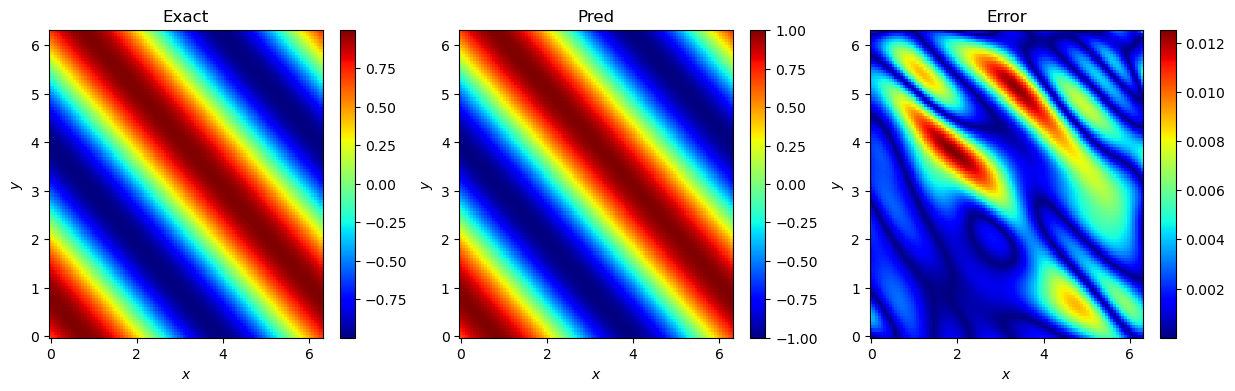

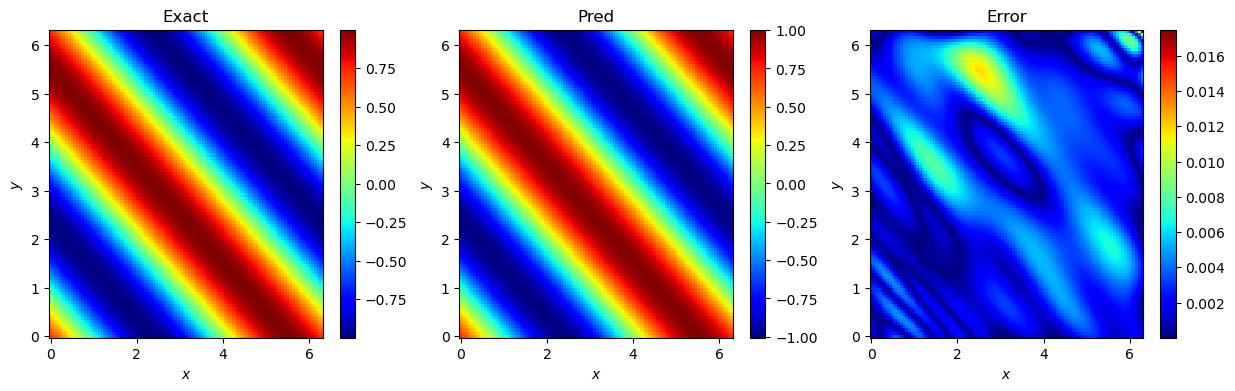

In [96]:
get_t_data(0.75)